<a href="https://colab.research.google.com/github/aatharvauti/vaccine-myths/blob/main/VaccineMyths_TopicModeling_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'reddit-vaccine-myths:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1187302%2F3167600%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T052110Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D80adb4c088ae0033452e070ea55b54cedb1b809f8195a0a4d47a320d50a9cfb03a1682ccfb2b9167acf647e63cb9b6af3bb8e04744195cd83831a4f379ee1b3e6660e5e3c58085d3df0049a9bc2a9fa00dd44aeafb4838455c5a9b045088c2a1e3798991f7fb45468ade603e1f83f2b484dae6809ae36872dd306f732c445f5b480f9f82c30d4aee180994e21978ff65a7d000afc0880a976fd403bdc381b656e8526ebc1c55fb0b942edb5e29d96052e6af723f7b262abdb4cf408ae8dbce14380525fd7e53a46c0b6243e7dd5e27158b0316678091e6a41d619c8ad810051cbfad69003d6e71144408ae050edf750ac96f01973ec93c3516d2b44328549eb4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Introduction

COVID-19 pandemic has affected the world in an unprecedented manner since the virus (SARS-CoV-2) was first identified in December 2019. To date, the virus has infected hundreds of millions of people and caused millions of deaths worldwide. Although more than 3 billion people globally were fully vaccinated, new variants of concern (e.g., Delta, Omicron) continued to emerge and strain the public health systems. Today, many of us still live with some levels of social distancing and travel restrictions.

Looking at the latest development of Covid-19 pandemic, it is likely that we need to take routine booster vaccine shots to protect ourselves and to "co-live" with the virus. Hence, it is insightful to look at how people think about vaccines (not limited to COVID-19 vaccines) as vaccine receptivity is essential to minimize the overall disease burden.

*\"It’s not vaccines that will stop the pandemic, it’s vaccination.\" - World Health Organization (WHO).*

In this project, we'll analyze Reddit posts from Subreddit **VaccineMyths** to perform the following:
- Sentiment analysis of user's posts and comments
- Topic modeling to extract hidden topics from the posts

From the results, we'll identify potential measures that might be helpful to debunk the common myths. Let's start by loading the required libraries and exploring the dataset.

In [ ]:
# !pip install -U pip setuptools wheel
!pip install spacy
# !python -m spacy download en_core_web_sm
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connection.py", line 175, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/opt/conda/lib/python3.7/site-packages/urllib3/util/connection.py", line 73, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/conda/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import spacy
import re, string
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob # sentiment analysis
from sklearn.decomposition import NMF # topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer # document-term matrix creation

%matplotlib inline

In [ ]:
# Set some default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('darkgrid')
plt.rc('figure', facecolor='#00000000', figsize=(10,8))
plt.rc('font', size=12)

# Explore the Dataset

Let's do a quick exploration of the dataset for understanding. First, load the dataset into `Pandas` dataframe.



In [ ]:
posts = pd.read_csv('../input/reddit-vaccine-myths/reddit_vm.csv')
posts.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [ ]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1602 non-null   object 
 1   score      1602 non-null   int64  
 2   id         1602 non-null   object 
 3   url        469 non-null    object 
 4   comms_num  1602 non-null   int64  
 5   created    1602 non-null   float64
 6   body       1226 non-null   object 
 7   timestamp  1602 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 100.2+ KB


We can see that there are 1,587 rows and 8 columns. Let's first understand what each column entails.

* `title` - title of post
* `score` - score of post based on impact, number of comments
* `id` - unique id for posts/comments
* `url` - url of post thread
* `commns_num` - number of comments to this post
* `created` - date of creation
* `body` - text of the post or comment
* `timestamp` - timestamp of creation

We do not need `id` and `url` for this analysis. Also, `created` (UNIX timestamp) and `timestamp` contains the same information, so we'll remove `created`.

In [ ]:
posts.drop(columns=['id', 'url', 'created'], inplace=True)
posts.head()

,title,score,comms_num,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,0,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,1,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,0,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,0,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,0,NaN,2021-02-16 11:36:28


There are some missing values under `body`, which is expected as some users might only share the post with title and `url` (which we already removed). Let's convert `timestamp` from *object* to *datetime* for subsequent analysis and plotting.

In [ ]:
posts['timestamp'] =  pd.to_datetime(posts['timestamp'], format='%Y-%m-%d %H:%M:%S')
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      1602 non-null   object        
 1   score      1602 non-null   int64         
 2   comms_num  1602 non-null   int64         
 3   body       1226 non-null   object        
 4   timestamp  1602 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 62.7+ KB


## Explore Creation Date and Impact of Posts

Let's see the breakdown of posts and comments in the dataset. There are 1,130 comments (~70%) out of 1,597 rows. The remaining 30% (n=467) are individual posts.

In [ ]:
sum(posts['title'] == 'Comment')

1133

Next, we sort by `score` to see what are the top 10 posts with the highest impact and/or number of comments.



In [ ]:
posts.sort_values(by=['score'], ascending=False).head(10)

,title,score,comms_num,body,timestamp
512,I would rage if this was handed to me...,1187,595,NaN,2014-04-02 05:32:42
510,From /r/Rage,45,13,NaN,2014-04-02 23:01:49
212,Vaccines exposed,38,4,NaN,2020-12-18 05:11:12
291,Do not give a platform for anti-vaxxers to pro...,32,5,I am of the mind to report social media groups...,2019-02-12 01:04:08
465,Meet my friend's anti-vax wife,32,1,NaN,2014-04-29 22:47:41
276,Vaccines have a huge side effect,30,13,"Vaccines have a huge side effect, vaccines are...",2019-06-08 11:16:35
301,Oh no! I got vaccinated!,28,6,"\n\n\nAnd I'm completely fine, do some researc...",2018-11-21 20:35:02
238,How ironic,28,3,NaN,2020-03-06 11:19:39
246,Vaccinate folks.,27,7,NaN,2020-01-09 03:25:37
586,Why Trust Scientists?,26,1,NaN,2014-01-17 10:16:45


We can see the most impactful post has much more comments (n=595) than the other posts. We will analyze the sentiment of the comments later on. Looking at the post title, more of the top 10 posts do not seem to advocate vaccination.

Let's see the distribution of these posts and comments over the years.

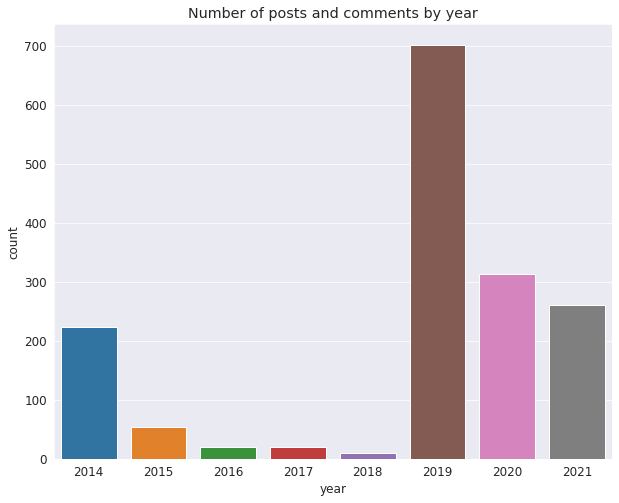

In [ ]:
# Extract year and month of the data
posts['year'] = pd.DatetimeIndex(posts['timestamp']).year
posts['month'] = pd.DatetimeIndex(posts['timestamp']).month

# Create a count plot
sns.countplot(x='year', data=posts)
plt.title('Number of posts and comments by year')
plt.show()

From the plot, we know that Reddit community was created in 2014. Ever since, the number of posts and comments was downtrending until a surge in 2019. Let's see if the surge of vaccine discussions was related to COVID-19, which was first known in December 2019.

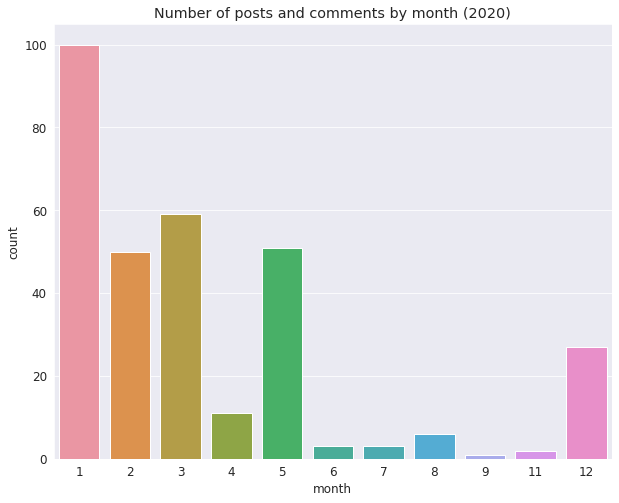

In [ ]:
sns.countplot(x='month', data=posts.loc[posts['year'] == 2020])
plt.title('Number of posts and comments by month (2020)')
plt.show()

We've completed the data exploration. Next, let's analyze sentiments and extract hidden topics (based on `title`) from the data. We'll start by preprocessing the texts.

# Text Preprocessing

It is important to make the text machine friendly before analysis. Hence, we'll apply the following steps to preprocess the text: convert words into lowercase, remove website link, remove special characters (e.g., number, emoji), remove punctuation, remove newline character, remove extra spaces and remove stopwords.

We'll be using [spaCy](https://spacy.io/), which is an open-source software library for advanced natural language processing (NLP), written in the programming languages Python and Cython.

In [ ]:
def preprocess(sentence):
    """
    Convert text to lowercase
    Remove website link, special characters, newline character and extra spaces
    """
    sentence = str(sentence)
    sentence = sentence.lower()
    rem_spe_chr = re.sub(r"[-()\"#/@;:<>\[\]{}`+=~|.!?,]", "", sentence)
    rem_url = re.sub(r'http\S+', '', rem_spe_chr)
    rem_url = re.sub(r'www\S+', '', rem_url)
    rem_nl = re.sub(r'\n', ' ', rem_url)
    rem_num = re.sub(r'[0-9]+', '', rem_nl)
    rem_space = re.sub(r'\s\s+', ' ', rem_num)
    return rem_space

# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Add stopwords
STOP_WORDS.update(['vaccine', 'vaccination', 'vaccinate', 'vaccinated', 'use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'find', 'read', 'point'])

def lemmatize(sentence):
    # Create Doc object and disable components we don't need (for efficiency)
    doc = nlp(sentence, disable=['ner', 'parser'])

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    alp_lemmas = [lemma for lemma in lemmas
                  if lemma.isalpha() and lemma not in STOP_WORDS]

    return ' '.join(alp_lemmas)

In [ ]:
# Create another dataframe that contains the cleaned text
posts_cleaned = posts.copy()

# Preprocess and lemmatize the title (non-comment) and body
posts_cleaned.loc[posts_cleaned['title'] != 'Comment', 'title'] = posts_cleaned.loc[posts_cleaned['title'] != 'Comment', 'title'].apply(preprocess).apply(lemmatize)
posts_cleaned.loc[~posts_cleaned['body'].isnull(), 'body'] = posts_cleaned.loc[~posts_cleaned['body'].isnull(), 'body'].apply(preprocess).apply(lemmatize)
posts_cleaned.tail()

,title,score,comms_num,body,timestamp,year,month
1597,Comment,2,0,lol comprehension comprehensive look post thin...,2019-04-25 23:11:10,2019,4
1598,Comment,1,0,trouble thing trouble thing try I clever quip ...,2019-04-25 23:02:04,2019,4
1599,Comment,0,0,music play dance,2019-04-25 22:53:50,2019,4
1600,Comment,1,0,long ethyl mercury metabolize happen brain lon...,2019-04-25 22:35:39,2019,4
1601,Comment,1,0,sound I scrape barrel bounce erratically fully...,2019-04-25 22:21:34,2019,4


Great! Now, we are ready to take the preprocessed text to perform sentiment analysis and topic modeling.

# Sentiment Analysis

Let's perform sentiment analysis to understand the opinion of the authors about the vaccines. We'll first generate a wordcloud to see what were the common words mentioned by the author.  

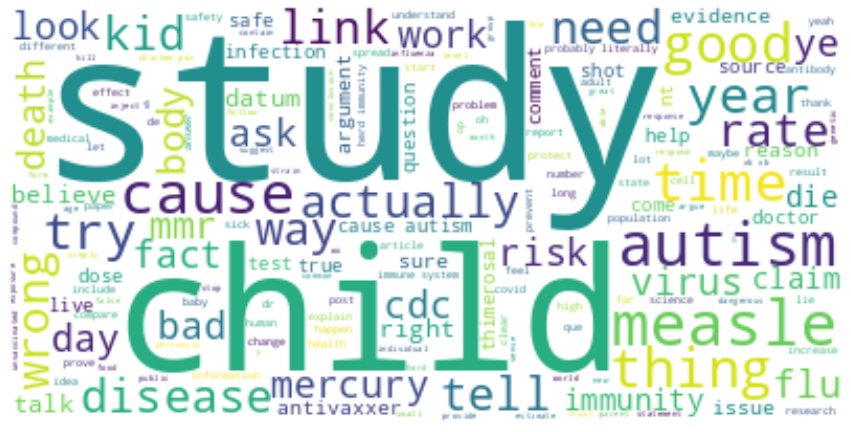

In [ ]:
# Import the word cloud function
from wordcloud import WordCloud

# Iterate through body column to join the text in all rows
body_words = ''
for sentence in posts_cleaned.loc[~posts_cleaned['body'].isnull(), 'body']:
    body_words += str(sentence) + ' '

# Create and generate a word cloud image
my_cloud = WordCloud(background_color='white', stopwords=STOP_WORDS, max_words=200).generate(body_words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the wordcloud, we can see some common words like study, child, autism, measle, good and time. As we cannot infer the semantic meaning of a sentence using wordcloud, let's use **TextBlob**, a simple Python Library which allows us to perform sentiment analysis using lexicon-based approaches (i.e., define sentiment by semantic orientation and intensity of each word in a sentence).

TextBlob returns two properties of a given input sentence:
*   **Polarity**: lies within [-1, 1]. -1 defines a negative sentiment, 1 defines a positive sentiment and 0 defines a neutral sentiment. TextBlob has semantic labels to recognize emoticons, exclamation marks, emojis, etc. Hence, we'll use the original `body` column (before removal of special characters) for analysis to preserve its semantics.
*   **Subjectivity**: lies within [0, 1]. The higher the score (toward 1), the more personal opinion (instead of factual information) the sentence contains.



In [ ]:
# Create columns for sentiment and subjectivity
posts['sentiment'] = np.NaN
posts['subjectivity'] = np.NaN

def basic_preprocess(sentence):
    """Perform basic preprocessing of text without removing special characters"""
    sentence = str(sentence)
    rem_url = re.sub(r'http\S+', '', sentence)
    rem_url = re.sub(r'www\S+', '', rem_url)
    rem_nl = re.sub(r'\n', ' ', rem_url)
    rem_space = re.sub(r'\s\s+', ' ', rem_nl)
    return rem_space

def get_sentiment(sentence):
    """Extract sentiment from text based on polarity value"""
    if sentence != '':
      score = TextBlob(sentence).sentiment.polarity
      if score < 0:
          return "Negative"
      elif score == 0:
          return "Neutral"
      else:
          return "Positive"

def get_subjectivity(sentence):
    """Calculate subjectivity of text"""
    return TextBlob(sentence).sentiment.subjectivity

In [ ]:
# Apply basic preprocessing for body text
posts.loc[~posts['body'].isnull(), 'body'] = posts.loc[~posts['body'].isnull(), 'body'].apply(basic_preprocess)

# Populate the sentiment and subjectivity
posts.loc[~posts['body'].isnull(), 'sentiment'] = posts.loc[~posts['body'].isnull(), 'body'].apply(get_sentiment)
posts.loc[~posts['body'].isnull(), 'subjectivity'] = posts.loc[~posts['body'].isnull(), 'body'].apply(get_subjectivity)

Let's take a look at the breakdown of sentiments of the body text.

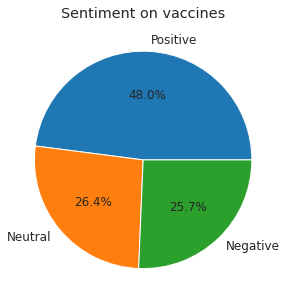

In [ ]:
# Create a pie chart
fig, ax = plt.subplots(figsize=(8,5))
ax.pie(posts['sentiment'].value_counts(normalize=True), labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%')
ax.set_title('Sentiment on vaccines')
plt.show();

We can see that ~48% of the text sentiments are classified as positive, ~26% as neutral and ~26% as negative. Let's randomly select a few positive and negative sentiments to see how TextBlob has performed in classifying the sentiment.

In [ ]:
list(posts.loc[posts['sentiment'] == 'Positive', 'body'].sample(5))

['>1) why are you getting so defensive about a youtube link? Did I say anything disparaging about learning through Youtube? Calm down. Because for some reason most people say to me "yeah a bunch of YouTube videos are really good proof" and it\'s like they are!! If they contain Evidence and science. >2) i never said Andrew Wakefield was jailed. But he did lose his medical license and has been discredited over and over again. Again, discredited doesn\'t mean fairly discredited. I can discredit Einstein all I want doesn\'t make him wrong. >3) you lose all credibility if you bring up Andrew Wakefield in any anti-vax argumen Well only if of course you believe that Andrew Wakefield was wrong. And even if he was, it still doesn\'t discredit my argument because that would be a fallacy of containment.. because something contains a false piece of information, doesn\'t mean that the rest is also false. It\'s just an easy way for you to ignore and to rationalize not being reasonable. >) not intere

In [ ]:
list(posts.loc[posts['sentiment'] == 'Neutral', 'body'].sample(5))

["I created the Vaxfact site using references to reliable sources, I understand you don't like the way I did some calculations, but all the data I based the calculations on was from the CDC",
 'Also, how would you draw up the micro chip from a multi use vial?',
 'Aki hülye haljon bele!',
 'C r e a m e d C o r n',
 'You got it bud']

In [ ]:
list(posts.loc[posts['sentiment'] == 'Negative', 'body'].sample(5))

['The fact that human society is continually being referred to in the media as a "herd," as though we were just a bunch of animals, is, at the base level, ominous.',
 'I believe science is ever changing, ever evolving and the current medical teaching is only lacking, focused on treating symptoms rather than increasing heath and preventing disease. I’d say the Drs in this story could be considered “pro-disease”, no? “All truth passes through three stages. First, it is ridiculed. Second, it is violently opposed. Third, it is accepted as being self-evident.” – Arthur Schopenhauer Tobacco industry lies CDC in 1958 says cigarettes don’t cause cancer. It is now universally recognized and accepted that cigarettes DO cause cancer.',
 'You cannot catch shingles from a vaccine you got, as none of those vaccines you list contain the virus that caused shingles, whether the blatant virus in your body was able to flare up due to immune system effects of the vaccine is a question for r/Immunology',
 

It seems like the classification is reasonable, although not highly accurate. This is expected as lexicon-based sentiment analysis might not handle different words (e.g., slang, informal words used on social media) in different contexts well because the sentiment is predicted based on pre-defined rules which might not be adapted to the specific domain.

If we have labeled historical datasets, we can train a machine learning model (e.g., Naive Bayes classifier, logistic regression) to predict the sentiments. Generally, this approach would yield a higher accuracy as the model can learn "patterns" from the labeled dataset.

Before we move on to topic modelling, let's take a quick look at the summary statistics and distribution of subjectivity of the texts.

In [ ]:
posts['subjectivity'].describe()

count    1226.000000
mean        0.401241
std         0.283161
min         0.000000
25%         0.168750
50%         0.439583
75%         0.583929
max         1.000000
Name: subjectivity, dtype: float64

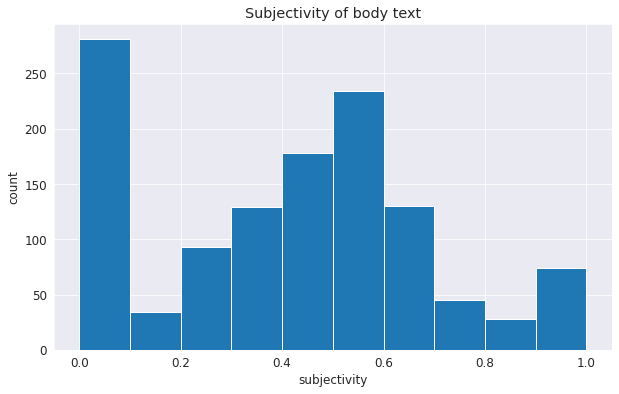

In [ ]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(posts['subjectivity'])
plt.title('Subjectivity of body text')
plt.xlabel('subjectivity')
plt.ylabel('count')
plt.show();

The mean subjectivity is ~0.4. If using 0.5 as a guide, a higher proportion of posts and comments are less subjective.

# Topic Modeling

It is interesting to see if we can extract prevailing topics from the posts. Here, we would use a technique called non-negative matrix factorization (NMF), which decomposes the **document-term matrix** into two smaller matrices - **document-topic matrix** and **topic-term matrix**. A document is composed of a mix of topics, and a topic is composed of a mix of terms.


We will exclude pure comments from the topic modeling as the comments are the responses to the `title`. Before fitting the model, let's look at the word count distribution of each title.

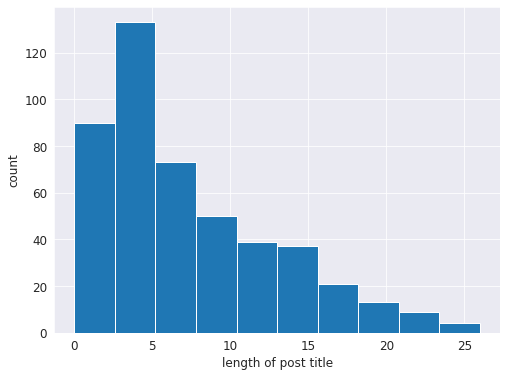

In [ ]:
def count_words(string):
    """Count the number of words in each string"""
    words = string.split()
    return len(words)

# Extract posts with title (exclude comments)
posts_with_title = posts_cleaned[posts_cleaned['title'] != 'Comment'].copy()

# Calculate the sentence length
posts_with_title['title_word_count'] = posts_with_title['title'].apply(count_words)

# Plot sentence length distribution
plt.figure(figsize=(8,6))
plt.hist(posts_with_title['title_word_count'])
plt.xlabel('length of post title')
plt.ylabel('count')
plt.show();

In general, >50% of the post titles are less than 10 words.

Now, we need to turn the post titles into numbers as the model does not understand texts. We'll use scikit-learn [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create term frequency-inverse document frequency (tf-idf) matrix. In essence, this formula will weigh each word based on its appearance in a document (i.e., a single post title here) and its appearance across the entire corpus (i.e., all the post titles here). If a word appears in many documents, its weightage (tf-idf) will be reduced as it doesn't mean much to the document in particular.

Read [here](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089) for more detailed explanation of tf-idf.

In [ ]:
# Create tf-idf matrix - ignore terms that have a document frequency strictly higher than 95% and less than 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(posts_with_title['title'].values.astype(str))

print(tfidf.shape)

(469, 513)


We now have a document-term matrix with shape of (467, 507), i.e., 467 titles (documents) and 507 vocabularies. We can use this as the input to scikit-learn [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) model. Let's set the number of topics as 5.

**It is important to pick the right number of topics as too few topics produce results that are too broad, while too many topics product results that are highly similar. However, there is currently no means to score NMF model in scikit-learn. For those who are interested, you can try Gensim's LDA topic modeling, for which a metric called "coherence score" can be used to compare models with different number of topics. In this analysis, we will stick to NMF model.*

In [ ]:
# Fit NMF model to post titles
nmf = NMF(n_components=5, random_state=1).fit(tfidf)
nmf_output = nmf.fit_transform(tfidf)
print(nmf_output.shape)

(469, 5)


The NMF output is a non-negative matrix that represents the document-topic matrix with a shape of (467, 5). Let's create a function to display the topics and the top 10 words in each topic.

In [ ]:
def get_topic_keywords(vectorizer, model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        # Find the indices of top n words with the highest weightage
        top_keyword_locs = (-topic_weights).argsort()[:n_words]

        # Extract the keywords based on indices
        topic_keywords.append(keywords.take(top_keyword_locs))

    return topic_keywords

# Get the top 10 words for each topic
topic_keywords = get_topic_keywords(vectorizer=tfidf_vectorizer, model=nmf, n_words=10)

# Display the topic and its top 10 keywords
for i in range(len(topic_keywords)):
    print("Topic {}: {}".format(i, ' '.join(topic_keywords[i])))

Topic 0: autism cause mmr link court proof cdc owner prove bad
Topic 1: covid canada penicillin magnetic la pfizer coronavirus actually prevent available
Topic 2: measle myth outbreak body mump chance polio baby die daughter
Topic 3: child unvaccinated parent reason polio year mmr immunity choose right
Topic 4: help need antivax debunk antivaxxer anti new discuss podcast vax


Looking at the keywords from each topic, we can postulate what each topic might be.

* Topic 0: debate about link of vaccine (mmr) with autism
* Topic 1: approval/use of COVID-19 vaccine in the world
* Topic 2: safety of vaccine
* Topic 3: vaccination uptake in children and its link with parent
* Topic 4: anti-vaccination and vaccine myths

Let's assign the post titles to the topic that constitutes the highest weightage among all the 5 topics.



In [ ]:
# Get the index of the highest topic weightage
posts_with_title['topic'] = nmf_output.argmax(axis=1)
posts_with_title.head()

,title,score,comms_num,body,timestamp,year,month,title_word_count,topic
0,health canada approve astrazeneca covid,7,0,NaN,2021-02-27 06:33:45,2021,2,5,1
1,covid canada passport near certainty bioethicist,2,1,NaN,2021-02-26 07:11:07,2021,2,6,1
2,coronavirus variant fuel canada wave,6,0,NaN,2021-02-21 07:50:08,2021,2,5,1
3,canadian government extend covid emergency ben...,1,0,NaN,2021-02-20 06:35:13,2021,2,6,1
4,canada pfizer extremely committed meet deliver...,6,0,NaN,2021-02-16 11:36:28,2021,2,7,1


We can look at the percentage of each topic and find out the most representative post title for each topic.

In [ ]:
posts_with_title['topic'].value_counts(normalize=True)

4    0.334755
3    0.264392
0    0.211087
2    0.102345
1    0.087420
Name: topic, dtype: float64

In [ ]:
# Extract the document that has the highest weightage under each topic
posts_with_title.iloc[nmf_output.argmax(axis=0)]

,title,score,comms_num,body,timestamp,year,month,title_word_count,topic
245,cause autism,0,9,wonderful daughter hailey autism autistic doct...,2020-01-11 12:51:59,2020,1,2,0
135,cast covid volunteer freezer truck driver,6,0,NaN,2021-03-02 02:58:59,2021,3,6,1
218,measle overview,3,0,NaN,2020-11-25 09:34:22,2020,11,2,2
298,child,21,24,mom extremely antivax swear let I long live I ...,2019-01-03 06:41:44,2019,1,1,3
267,I need help debunk,5,1,NaN,2019-08-28 07:40:54,2019,8,4,4


Most posts (\~34%) were related to topic 4 (anti-vaccination and vaccine myths), while topic 1 (COVID-19 vaccine approval and use) has the lowest number of posts (~8%).

The most representative post title each topic seems to tally with our postulation (except for topic 2). Let's look at more posts under topic 2.

In [ ]:
list(posts_with_title.loc[posts_with_title['topic'] == 2, 'title'].sample(10))

['hydration cold rag need measle work wonder apparently hype death measle',
 'measle urge amid disneyland outbreak',
 'antivaccine body count',
 'homeopath scam practitioner peddle dangerous myth',
 'sign petition wakefield measle',
 'myth measle fatal',
 'wait',
 'check rhealthyskepticism subreddit discussion kind medical myth',
 'melanie marvelous measle',
 'myth thimerosal mercury']

These posts seem to be related to safety profile of vaccine (topic 2). Our NMF topic model has a reasonable performance.

From the topic modeling outputs, we can see potential areas (e.g., vaccine use and autism, thimerosal/mercury in vaccine) that might contribute to vaccine hesitancy and skepticism. More targeted education on vaccination can be considered.

# Conclusion

We have come to the end of this analysis. From sentiment analysis and topic modeling, we observed the following:
* Around half of the sentiments were positive, with another half split between neutral and negative
* The discussions on Reddit were centered around autism, COVID-19 vaccine, vaccine safety, vaccination in children and anti-vaccination.

It is important not to forget the limitations of data, methodology and findings. Some of the limitations we have are listed:  
* Social media data is subjected to high bias - social media users are not representative of the underlying population.
* Results from Reddit data are not generalizable to all countries (a large proportion of Reddit users are located in the United States).
* We only have data from one Reddit community. There are other vaccine communities discussing different aspects of vaccines.
* We do not have labeled historical dataset to train machine learning model for sentiment prediction.
* NMF topic modeling in scikit-learn doesn't have score to compare models with different number of chosen topics. Other models such as Gensim's LDA can be considered.


# References

1. [WHO COVID-19 Dashboard](https://covid19.who.int/)
2. [Sentiment Analysis Using TextBlob](https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524)
3. [Non-negative Matrix Factorization - Python Implementation](https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8)
4. [Topic Modeling with NMF](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45)

Project Created by
- Atharva Auti (BE15-01)
- Aryan Doshi (BE15-08)
- Vishal Padia (BE15-26)
- Sahil Sakpal (BE15-38)